# Analysis of natural language in Github issues

### Language identification

We analyze a 2,000 subset of bigcode data.

In [174]:
from datasets import load_dataset

ds = load_dataset("bigcode/subset-github-issues", split="train", use_auth_token=True)

In [175]:
ds[0]

{'repo': 'justarrived/justarrived.github.io',
 'org': 'justarrived',
 'issue_id': 183724936,
 'issue_number': 80,
 'pull_request': None,
 'events': [{'action': 'opened',
   'author': 'tikkat',
   'comment': None,
   'comment_id': None,
   'datetime': 1476805329000,
   'description': '',
   'title': 'Mobile header with hamburger menu dropdown',
   'type': 'issue'},
  {'action': 'closed',
   'author': 'tikkat',
   'comment': None,
   'comment_id': None,
   'datetime': 1476994993000,
   'description': None,
   'title': None,
   'type': 'issue'}]}

In [176]:
# remove columns that are not needed
ds = ds.remove_columns(['repo', 'org', 'issue_id', 'issue_number', 'pull_request'])

In [177]:
#for description and title extract inside events, create a new column called text and concatenate title and description if they are both not None
ds = ds.map(lambda x: {'text': [e['title'] + e['description'] for e in x['events'] if e['title'] is not None and e['description'] is not None]})
#now convert the list of strings to a single string and remove the list
ds = ds.map(lambda x: {'text': ' '.join(x['text'])})

In [178]:
ds = ds.remove_columns(['events'])

In [179]:
ds[0]['text']

'Mobile header with hamburger menu dropdown'

In [182]:
from language_identifier import extract_nl_text, FunctionDatasetModifyingDocuments

In [183]:
dataset = ds.select([i for i in range(2000)])
# extraction of NL
dataset = dataset.map(extract_nl_text)

  0%|          | 0/2000 [00:00<?, ?ex/s]

Two new columns in the dataset: nl_text with a string where the extracted dosctrings and comments are concatenated, nl_size: size of nl_text

In [184]:
dataset

Dataset({
    features: ['text', 'nl_text', 'nl_size'],
    num_rows: 2000
})

Text(0.5, 1.0, 'distribution of the size of issues titles+comments (on a 2k subset)')

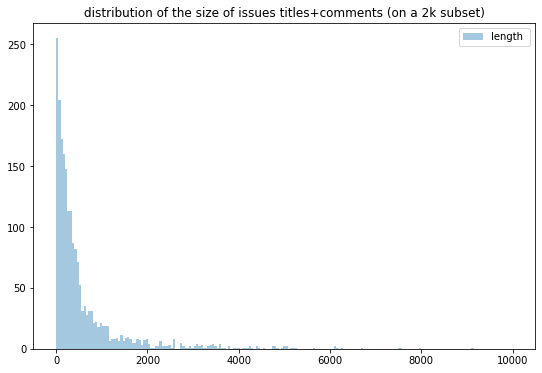

In [185]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of issues titles+comments (on a 2k subset)")

Now let's identify languages

In [186]:
path_fasttext_model = "fasttext_model/lid.176.bin"
func_dataset_modifying_documents = FunctionDatasetModifyingDocuments(
    path_fasttext_model
)

In [187]:
dataset[0]["nl_text"]

'Mobile header with hamburger menu dropdown'

In [188]:
output = func_dataset_modifying_documents(dataset[0])

In [189]:
output.keys()

dict_keys(['text', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'])

In [190]:
print(f"detected language id is: {output['nl_language']}")
print(f"Model prediction score of the language: {output['nl_language_score']}")

detected language id is: en
Model prediction score of the language: 0.4267280399799347


In [191]:
print(dataset[4]["nl_text"])

add HTTP Proxy support to AIOThis PR adds HTTP Proxy support to the AIO installer via Hiera. Relies on the behavior to soucre `/etc/environment`, all supported systems do either natively or via system init scripts.


In [192]:
output2 = func_dataset_modifying_documents(dataset[4])
print(f"detected language id is: {output2['nl_language']}")
# zh stands for Chinese
print(f"Model prediction score of the language: {output2['nl_language_score']}")

detected language id is: en
Model prediction score of the language: 0.6716512441635132


In [193]:
dataset[0]["nl_text"]

'Mobile header with hamburger menu dropdown'

Now let's run language detection on the full 2,000 samples subset

In [194]:
# Could be improved by allowing multiprocessing with map (currently doesn't work)
dataset_language = dataset.map(
    func_dataset_modifying_documents, num_proc=1
)  # num_proc=cpu_count()
print("Fasttext done")

  0%|          | 0/2000 [00:00<?, ?ex/s]

Fasttext done


In [195]:
dataset_language

Dataset({
    features: ['text', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'],
    num_rows: 2000
})

In [196]:
ratio = sum([1 if dataset_language["nl_language"][i] != "en" else 0 for i in range(len(dataset))])/len(dataset)
print(f"percentage of non english detected languages {ratio*100}%")

percentage of non english detected languages 4.05%


In [197]:
#languages that are'n english in the first 200 samples = 8%
L = []
for i in range(200):
    if dataset_language["nl_language"][i] != "en":
        L.append(i)
        print(i)

51
68
91
177
181
184


### successful detections

In [198]:
print(dataset_language["nl_language"][23])
print(dataset_language["nl_language_score"][23])
print(dataset_language["nl_text"][23])

en
0.2168474644422531
SyntaxError: Use of const in strict mode.Command: ` $ wat css animation `
Path: `/node_modules/wat/bin/index.js:5`
Error:
````js
const uh = require("./../");
^^^^^
SyntaxError: Use of const in strict mode.
    at exports.runInThisContext (vm.js:73:16)
    at Module._compile (module.js:443:25)
    at Object.Module._extensions..js (module.js:478:10)
    at Module.load (module.js:355:32)
    at Function.Module._load (module.js:310:12)
    at Function.Module.runMain (module.js:501:10)
    at startup (node.js:129:16)
    at node.js:814:3
````
Node version: `v0.12.6`


In [199]:
print(dataset_language["nl_language"][52])
print(dataset_language["nl_language_score"][52])
print(dataset_language["nl_text"][52])

en
0.8968048691749573
Content goes off the page (and prevents scrollbars?)Bug report by email.  I can't repro this on my browsers but there's a screenshot attached.

> Haven't managed to reproduce the FF
display issues again, but here is an example of the "no scrollbars"
problem in Chrome (well, Chromium, really). It's all the more annoying
since the arrows are hijacked by the page. With FF + Vimperator, it is
possible to scroll with 'J/K' and see the rest of the text.

![chromium_presentation_issue](https://cloud.githubusercontent.com/assets/121855/5518441/3b898940-8920-11e4-901d-7a7136f49534.png)



In [200]:
print(dataset_language["nl_language"][75])
print(dataset_language["nl_language_score"][75])
print(dataset_language["nl_text"][75])

en
0.5903511643409729
Adds itemSetIdentifier to Item.hs and changeIdentifier to Compiler.hs.Hello @jaspervdj and contributors. :)

This change allows one to change/set the identifier of an Item.

Use case:

Say someone wants to show their most recent post on the home page in its entirety.

```haskell
-- /site.hs
-- ...
  create ["index.html"] $ do
    route idRoute
    compile $ do
      post <- fmap head . recentFirst =<< loadAllSnapshots "posts/*" "content"
      loadAndApplyTemplate "templates/default.html" postCtx post
        >>= relativizeUrls
        >>= changeIdentifier "index.html"
-- ...
```
```html
<!-- "templates/default.html" -->
<html>
  <head>
    <meta property="og:url" content="$url$">
    <title>$title$</title>
  </head>
  <body>
    $date$
    $body
  </body>
</html>
```

This will allow them to create or match a page with a different identifier than the one they wish to load. In this example they are loading say Identifier `posts/yyyy-mm-dd-my-recent-post.markdown` 

In [201]:
print(dataset_language["nl_language"][77])
print(dataset_language["nl_language_score"][77])
print(dataset_language["nl_text"][77])

en
0.7570561170578003
remove MACOS folder from the zip-file of MARA download


In [202]:
print(dataset_language["nl_language"][138])
print(dataset_language["nl_language_score"][138])
print(dataset_language["nl_text"][138])

en
0.968618631362915
In /contributors checkUnsure why at yesterday's event someone was getting an error, so look back into this logic. 


In [203]:
print(dataset_language["nl_language"][143])
print(dataset_language["nl_language_score"][143])
print(dataset_language["nl_text"][143])

en
0.5260642170906067
Proposing Animate componentThis will allow components to transition in & out.

![animate component](https://cloud.githubusercontent.com/assets/3210082/16730986/876e95d4-4711-11e6-8429-81f7643e7c0d.gif)



### failures:

In [204]:
print(dataset_language["nl_language"][79])
print(dataset_language["nl_language_score"][79])
print(dataset_language["nl_text"][79])
print("\n")
print(dataset_language["nl_language"][11])
print(dataset_language["nl_language_score"][11])
print(dataset_language["nl_text"][11])
print("\n")
print(dataset_language["nl_language"][110])
print(dataset_language["nl_language_score"][110])
print(dataset_language["nl_text"][110])
print("\n")
print(dataset_language["nl_language"][139])
print(dataset_language["nl_language_score"][139])
print(dataset_language["nl_text"][139])

en
0.43210530281066895
Implement copy method for transfer managercc @jamesls @JordonPhillips 


en
0.4001844823360443
java 8 javadoc linthttp://stackoverflow.com/questions/15886209/maven-is-not-working-in-java-8-when-javadoc-tags-are-incomplete

            <configuration>
                <additionalparam>-Xdoclint:none</additionalparam>
            </configuration>

under java 8 profile


en
0.5154730677604675
Update en_US.langThe line 'achievement.alchemicalwizardy:firstPrick!' turns out to be 'achievement.alchemicalwizardy:achievment.firstPrick'
Sorry for not seeing the error before.


en
0.8865142464637756
How to configure swagger-ui.html prefix url to accessI tried to rewrite the place where browser can view the swagger-ui.html.

It is needed because our loadbalancer is configured on special prefix in url,
but I did not suceed to rewrite or configure it.

Any idea?


Text(0.5, 1.0, 'distribution of the size of issues titles+comments (on a 2k subset)')

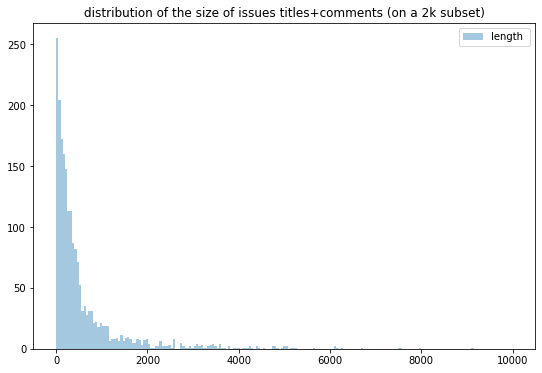

In [207]:
#distribution of langauges

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of issues titles+comments (on a 2k subset)")

In [208]:
type(dataset_language["nl_language"])

list

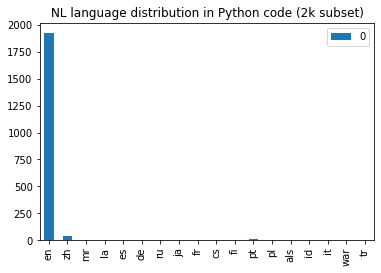

In [209]:
import pandas
from collections import Counter
letter_counts = Counter(dataset_language["nl_language"])
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', title="NL language distribution in Python code (2k subset)")